# Data Scientist Challenge - LATAM Airlines

### Busqueda bibliográfica

Lo primero que hice fue una búsqueda bibliográfica no demasiada extensa por cuestiones de tiempo, para intentar ver qué había hecho sobre el tema, se encontraron algunos artículos y páginas interesantes:

https://ddd.uab.cat/pub/tfg/2016/169883/MartinezDomenechNerea-TFGAa2015-16.pdf (Este documento que aparentemente es una tesis de grado, fue util para como referencia de variables y algoritmos usados. Además tiene la estimación del beneficio económico de prevenir retrasos en vuelos. Algo que no siempre es fácil de conseguir en los proyectos de DS)

https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial (este articulo en formato jupyter notebook puede ser util para obtener ideas si es necesario hacer una exploración de datos más detallada, y como referencia de variables usadas)

https://medium.com/@diegitsen/predecir-retrasos-de-vuelo-en-el-aeropuerto-de-madrid-parte-2-c%C3%B3digo-en-python-cc4c39222577 (este articulo finalmente no aportó mucho pero fue una buena referencia como para empezar a entrar en tema, ver qué había hecho y evitar repetir lo que ya es conocido.)


Por otro lado hice una exploración en PowerBI, que si bien no es parte del ejercicio, es una excelente herramienta para un primer encuentro con los datos, a mi entender superior a Jupyter/Python. En el pasado he obtenido resultados muy buenos por la velocidad con que se puede desplegar un tablero y empezar a jugar con el mismo. Creo que es bueno para un Científico de datos tener varias herramientas en la baulera. Se agregaron algunas capturas de los gráficos más interesantes para este caso.

In [3]:
#Importación de las ibrerías que se usaron en el notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from imblearn.over_sampling import SMOTE
#Para poder usar SMOTE hay que usar una version distinta de make_pipline, funcionó sin problemas y es compatible con sklearn
from imblearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn import tree

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_validate


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Datos

In [4]:
#Lectura de datos

df = pd.read_csv('data/dataset_SCL.csv')

#Algunas transformaciones que fueron necesarias

df[['Fecha-I', 'Fecha-O']] = df[['Fecha-I', 'Fecha-O']].astype('datetime64[ns]') # Esto es para poder hacer operaciones como dt.hour
df['Vlo-I'] = "'" + df['Vlo-I'].map(str) + "'" #Esto es para que no haya errores porque algunos vuelos eran numéricos y otros alfanuméricos
df['Vlo-O'] = "'" + df['Vlo-O'].map(str) + "'" #idem anterior

<a id='sectionej1'></a>
## Ejercicio 1: Visualización y primer entendimiento de los datos

1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

Introducción:  
  
Se considera que la intención de esta pregunta es que se haga una exploración preliminar y visualización de los datos sin limitarse al problema de predicción que enmarca el desafío.  
Por tal motivo se procedió a escribir un script que automáticamente tome todas las variables del dataset y las muestre en [Pie charts](#Pie_charts) y en [Bar charts](#Bar_charts) (con un limite de categorías).  
Como esto ocupa mucho espacio, hay algunos gráficos que carecen de sentido (por ejemplo Pie_chart: Fecha-I) y otros aportan poca información (como por ejemplo Pie_chart: Ori-O, ya que el 100% de los vuelos tienen origen en SCEL, es decir el aeropuerto de Santiago de Chile) se dejaron todos los gráficos en un [Apéndice](#Apendice). Y se traerán los más importantes a esta sección.
Por otro lado se exploró la información disponible en las funciones describe y info de pandas, por cuestiones de claridad la misma también se deja en la sección [Apéndice](#Apendice).
Asimismo se realizó un análisis exploratorio en PowerBI, que si bien no se puede visualizar  desde este notebook, como ya veremos, es una herramienta superior para navegar/explorar datos, disparador de ideas y preguntas para hacerle a los datos. De esta se tomaron las capturas más importantes y se incluyeron como imágenes.  
  
Exploración:  

Mirando la información del [Apéndice](#Apendice) vemos que hay 68205 filas de datos que cada una corresponde a un vuelo distinto, aparentemente no se ven faltantes o nulls. Las Fechas Programadas tienen un detalle de intervalos de 5 minutos, mientras que las Fechas de Operación tienen un detalle al minuto. La mayoría de las variables en la base de datos son categóricas, salvo las variables numéricas DIA, MES, AÑO, que se pueden derivar de la fecha. Como era de esperar la totalidad de los vuelos tienen como origen el aeropuerto SCEL. 
  
En la sección [Pie_charts_elegidos](#Pie_charts_elegidos): 
  
- Emp-I podemos observar que LAN es la empresa con mayor cantidad de vuelos con el 55.1 %, seguida por SKU.  
- En el gráfico OPERA se ve que el Grupo Latam tiene un porcentaje de vuelos aún mayor llegando al 60%.  
- TIPOVUELO muestra que el 54.2% de los vuelos es nacional siendo el resto internacional.  
- En SIGLADES podemos ver que las principales ciudades de destino, siendo la principal Buenos Aires seguida por Antofagasta.  

En la sección [Bar_charts_elegidos](#Bar_charts_elegidos):  

- Se puede ver en DIANOM que Viernes es el día con más vuelos, seguido por el Jueves.    
- En VlO-O vemos que el Número de vuelo programado que más veces viajó en el año fue el '174' con 649 vuelos, seguido por el '11' con 646 (detalles numéricos obtenidos mostrados en el [Apéndice](#Apendice).  
- Finalmente en Fecha-O se puede ver que la máxima frecuencia de vuelos es de 5 por minuto.
  
En la sección [Capturas PowerBI](#Capturas_PowerBI):  
  
- Primero podemos ver como los datos desplegados en un mapa, muestran claramente las rutas de las distintas aerolíneas. El caso de la primer captura es para los vuelos internacionales del Grupo LATAM.  
- También seleccionando los filtros se puede elegir ver solo las rutas nacionales para todos los operadores como el ejemplo de la segunda captura.  
  
- La siguiente captura muestra un Diagrama de Sankey donde por ejemplo podemos ver para los vuelos internacionales el Destino programado respecto al de operación. Se puede ver a simple vista que en ciertos casos, como el marcado con el cursor, hay cambios de destino. Esta información pude llegar a ser relevante para las predicciones y se discutirá más adelante.  
  
- Treemap complementa lo que ya vimos en [Pie_charts_elegidos](#Pie_charts_elegidos) mostrando la cantidad de Números de vuelo por Operador y Empresa. Si cada número de vuelo coincidiera con una aeronave distinta, estos números nos darían un buen indicio del tamaño de las distintas flotas que operan en SCEL.  
  
- Por último en el gráfico más interesante, vemos las Series Temporales de la cantidad de vuelos en función del tiempo para el caso de vuelos Nacionales (arriba) e Internacionales (abajo). Se puede apreciar que en los dos casos hay una cierta estacionalidad que aparentemente es semanal. Pero lo más interesante es que son marcadamente distintas. 
Para poder hacer esto más visible se usó el algoritmo Holt-Winters exponential smoothing disponible en PowerBI. Con el cual podemos apreciar en las predicciones marcadas en negro, que efectivamente hay estacionalidad y que es marcadamente distinta en las dos categorías. Para hacerlo aún más evidente se graficó la cantidad de vuelos totales por DIANOM, donde se ve que los días con mayor cantidad de vuelos difiere entre las categorías.  
En resumen se evidencia un comportamiento temporal claramente distinto entre vuelos I y N. Considerando además, que al final de cuentas, lo que estamos tratando de hacer es predecir comportamientos futuros analizando comportamientos pasados en los datos. Surge algunos importantes interrogantes:  Mejorarían estas predicciones si separamos los datos en I y N, y usamos un algoritmo para cada grupo de datos? De ser así habría que probar haciendo otras segregaciones adicionales? Habría que pensar en algoritmos específicos para ciertas categorías?

Comentario:  
Al jugar con los datos cambiando distintos filtros/categorías muy rápidamente, y haciendo una gran cantidad de pruebas en un corto tiempo en PowerBI. Se dispararon interrogantes para tratar de responder usando Python, ya que es una herramienta más apropiada para análisis más profundos.


### Pie_charts_elegidos

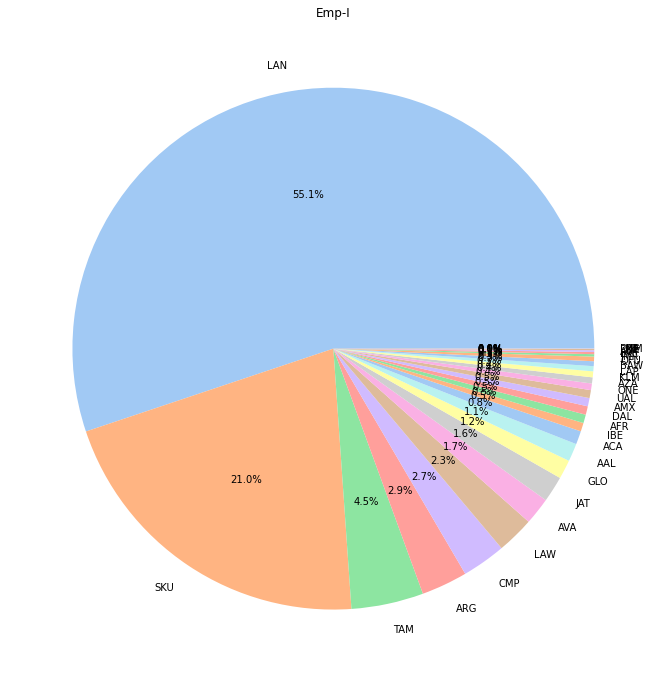

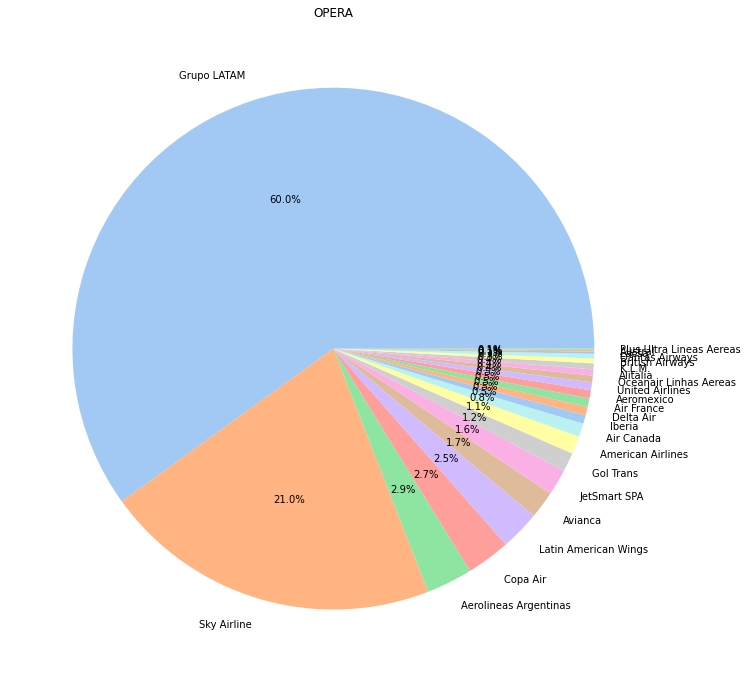

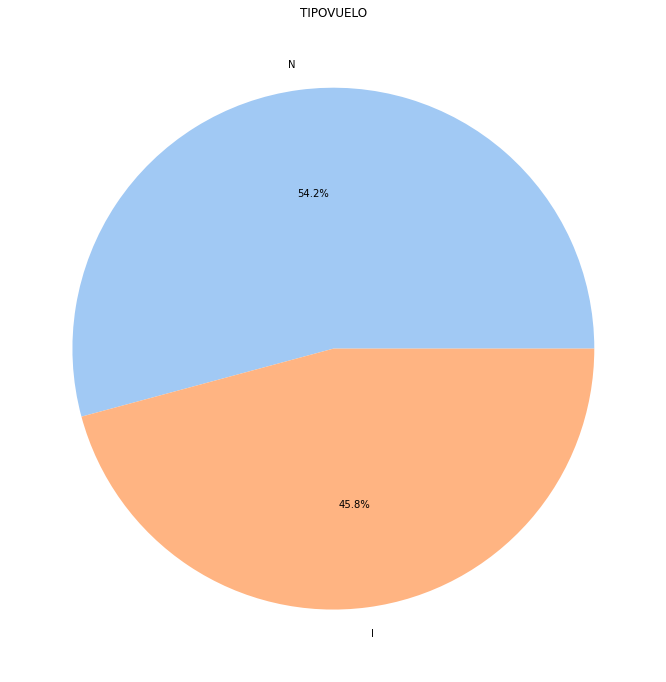

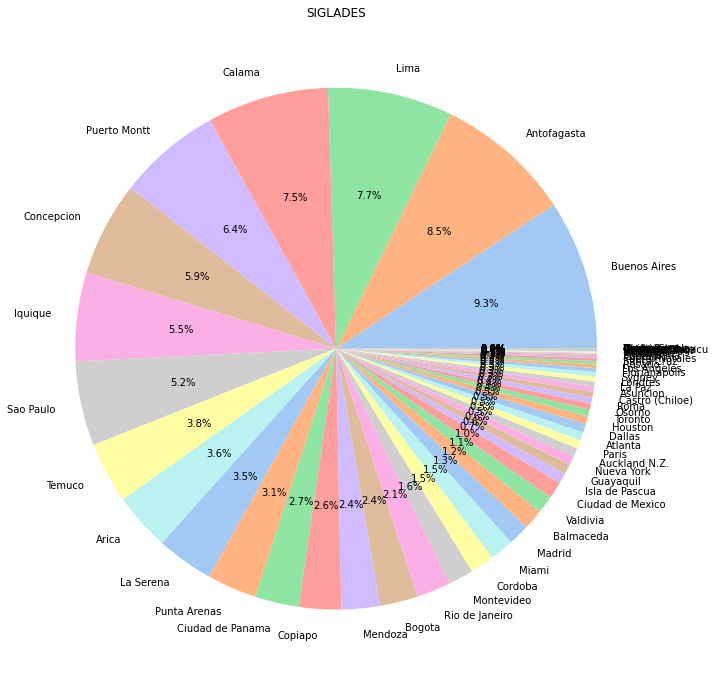

In [5]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_pie=df[['Emp-I','OPERA', 'TIPOVUELO','SIGLADES']]
for n in range(len(df_pie.columns)):
    colors = sns.color_palette('pastel')[0:len(df_pie[list(df_pie.columns.values)[n]].value_counts())]
    plt.figure(figsize=(12, 12))
    plt.title((df_pie.columns.values)[n])
    plt.pie(df_pie[list(df_pie.columns.values)[n]].value_counts().head(top),labels=df_pie[list(df_pie.columns.values)[n]].value_counts().head(top).index.tolist(), autopct='%1.1f%%', colors=colors)
plt.show()

### Bar_charts_elegidos

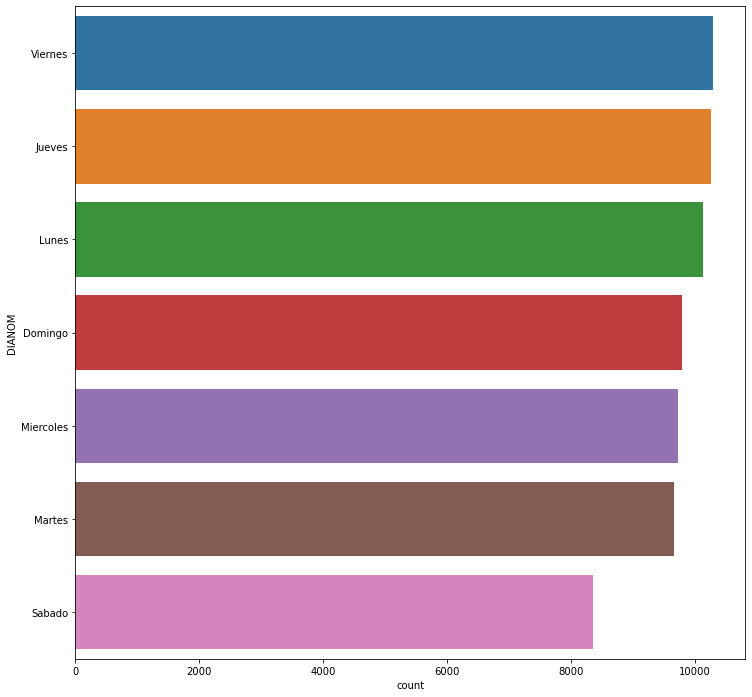

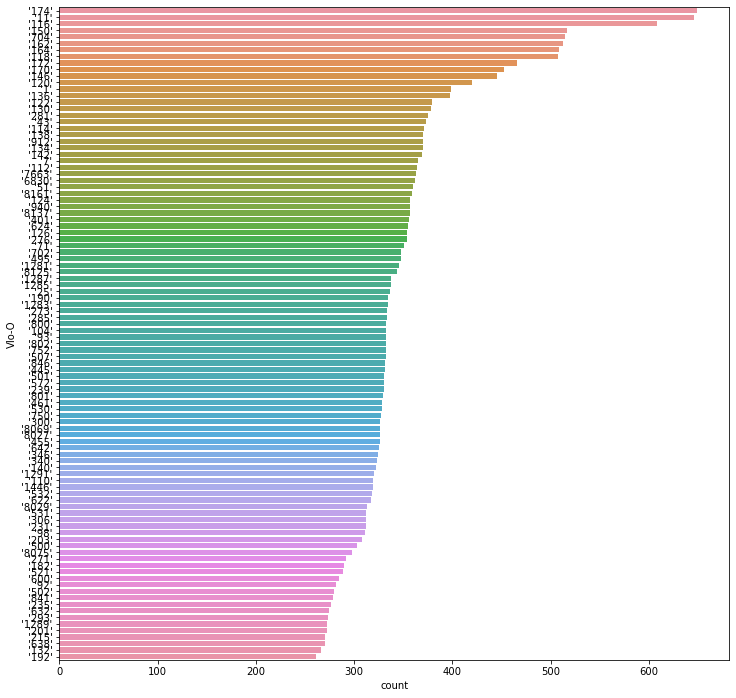

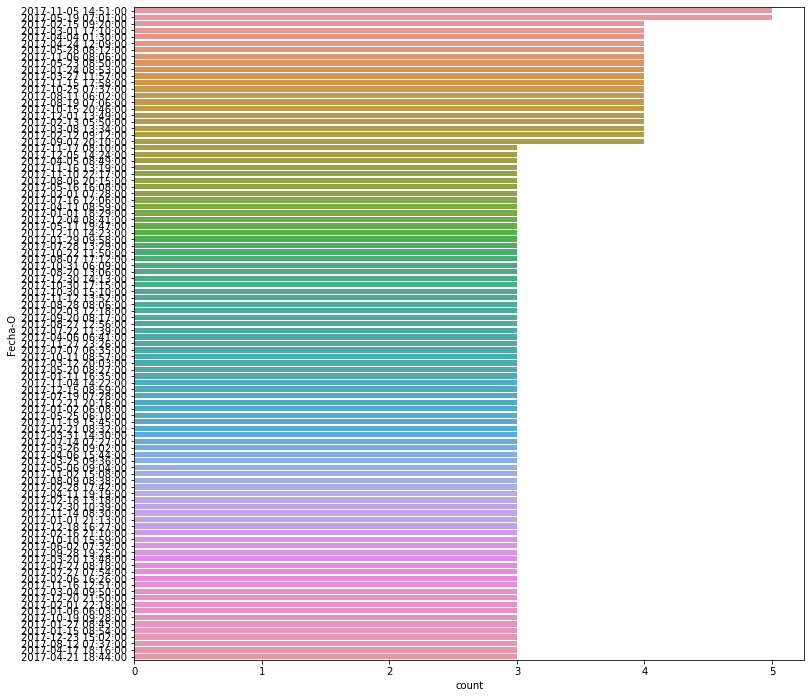

In [6]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_bar=df[['DIANOM', 'Vlo-O', 'Fecha-O']]
for n in range(len(df_bar.columns)):
    count_order = df_bar[list(df_bar.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df_bar, y=list(df_bar.columns.values)[n], order=count_order)
plt.show()


### Capturas_PowerBI

Mapa vuelos Internacionales:  

![title](img/PBI1.png)  

Mapa vuelos Nacionales:  

![title](img/PBI2.png)

Sankey:

![title](img/PBI3.png)

Treemap:  

![title](img/PBI4.png)

Series Temporales Nacionales e Internacionales:    

![title](img/PBI5_N.png)
![title](img/PBI5_I.png)

## Ejercicio 2: New features

2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.  DONE

- dif_min : diferencia en minutos entre Fecha-O y Fecha-I . DONE

- atraso_15 : 1 si dif_min > 15, 0 si no. DONE

- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I . DONE

(Todo comprobado usando la exportación a csv)

In [7]:
#Código que resuelve el Ejercicio 2
df2=df
df2['temporada_alta'] = np.where( ((df2['Fecha-I'].dt.month==12) & (df2['Fecha-I'].dt.day >=15)) | (df2['Fecha-I'].dt.month==1) | (df2['Fecha-I'].dt.month==2) | ((df2['Fecha-I'].dt.month==3) & (df2['Fecha-I'].dt.day <=3)) | ((df2['Fecha-I'].dt.month==7) & (df2['Fecha-I'].dt.day >=15) &  (df2['Fecha-I'].dt.day<=31)) | ((df2['Fecha-I'].dt.month==9) & (df2['Fecha-I'].dt.day >=11) & (df2['Fecha-I'].dt.day <=30)), 1, 0)

#Supuse que las las fechas que separan las temporadas forman parte de la temporada alta, si no es así se puede cambiar muy facilmente 


df2['dif_min']= (df2['Fecha-O']-df2['Fecha-I'])/np.timedelta64(1,'m')

df2['atraso_15'] = np.where(df2['dif_min'] > 15, 1, 0) 


conditions = [(df2['Fecha-I'].dt.hour >= 5) & (df2['Fecha-I'].dt.hour < 12), (df2['Fecha-I'].dt.hour >= 12) & (df2['Fecha-I'].dt.hour < 19), (df2['Fecha-I'].dt.hour >= 19) | (df2['Fecha-I'].dt.hour < 5)]
values = ['mañana', 'tarde', 'noche']
df2['periodo_dia'] = np.select(conditions, values)

df2.tail()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
68201,2017-12-22 14:55:00,'400',SCEL,SPJC,JAT,2017-12-22 15:41:00,'400.0',SCEL,SPJC,JAT,...,2017,Viernes,I,JetSmart SPA,Santiago,Lima,1,46.0,1,tarde
68202,2017-12-25 14:55:00,'400',SCEL,SPJC,JAT,2017-12-25 15:11:00,'400.0',SCEL,SPJC,JAT,...,2017,Lunes,I,JetSmart SPA,Santiago,Lima,1,16.0,1,tarde
68203,2017-12-27 14:55:00,'400',SCEL,SPJC,JAT,2017-12-27 15:35:00,'400.0',SCEL,SPJC,JAT,...,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,1,40.0,1,tarde
68204,2017-12-29 14:55:00,'400',SCEL,SPJC,JAT,2017-12-29 15:08:00,'400.0',SCEL,SPJC,JAT,...,2017,Viernes,I,JetSmart SPA,Santiago,Lima,1,13.0,0,tarde
68205,2017-12-31 14:55:00,'400',SCEL,SPJC,JAT,2017-12-31 15:04:00,'400.0',SCEL,SPJC,JAT,...,2017,Domingo,I,JetSmart SPA,Santiago,Lima,1,9.0,0,tarde


In [8]:
#Exporto nuevas variables al archivo csv solicitado
       
df2[['temporada_alta', 'dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv')

## Ejercicio 3: Tasas de atraso e importancia de variables

3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

Para visualizar las tasas de atraso, nuevamente se usó un script que automáticamente toma todas las variables, ahora del dataset ampliado, y muestra la cantidad de casos con atrasos y sin atrasos por categoría, y por otro lado un gráfico donde se puede ver el porcentaje de atrasos por categoría. Estos gráficos están pensados para usarse de a pares, ya que son complementarios entre si. Quedan todos disponibles en [Histoplots](#Histoplots), en el [Apéndice](#Apendice). Luego de un primer paneo general se seleccionaron los solicitados específicamente en este ejercicio para dejarse en [Histoplots_elegidos](#Histoplots_elegidos).

Analizando únicamente las tasas, se puede ver que hay diferencias notables entre las distintas categorías (lo que indicaría que pueden ser variables influyentes en la predicción) para los casos de destino (Des-I) y  aerolínea (OPERA). Sin embargo hay que tener mucha precaución en tomar conclusiones solo con esta variable ya que puede carecer de peso estadístico. Por ejemplo los destinos SLCB, EGYP, SEQU, SEQM  muestran una tasa de atraso del 100%, mirando este número uno podría pensar que en el futuro estos tienen un atraso asegurado, sin embargo al ver el número de casos, vemos que hubo solo 1 vuelo en cada uno de estos por lo que puede ser un resultado fortuito (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas). Por este motivo, se deben usar los gráficos complementarios con la cantidad de casos en conjunto con los que muestran las tasas. Además, el análisis visual debe ser considerado meramente como una orientación, fuente de ideas e interrogantes. Que luego deben ser comprobados con un análisis adicionales. 

Analizando las tasas de atraso por MES en [Histoplots_elegidos](#Histoplots_elegidos) podemos ver que aparentemente hay un mayor porcentaje para los meses 7 y 12.  
Y mirando los tasas según tipo de vuelo, vemos que hay un 22.56 % de atrasos para vuelos internacionales frente a un 15.06% para los nacionales (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas)), lo que representa un número 50 % mayor. Lo que coincide con la diferencia de comportamiento mencionada en el [Ejercicio 1](#sectionej1)  
DIANOM no aparenta visualmente diferencias de tasas notables, sin embargo en (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas)) podemos ver que el día con mayor tasa es 38% más grande que la tasa del menor. Con lo cual puede ser una variable con cierto peso en las predicciones.


Por otro lado en varios de los gráficos se puede evidenciar que la base de datos está desbalanceada, habiendo un 18.5 % de atrasos y un 82.5 % de vuelos que no superaron los 15 minutos de diferencia entre el horario programado y el de operación (esto puede traer problemas y fue discutido más adelante). Estos números se pueden observar en la sección [Detalles_numerico_desbalance](#Detalles_numerico_desbalance).

Por ultimo haciendo pruebas en PowerBI encontramos una relación muy interesante entre la suma de dif_min y la cantidad de vuelos por hora, ya que parece que hay una marcada relación entre estas (ver primer gráfico en [Capturas_PowerBI_2](#Capturas_PowerBI_2) . Por lo que se hizo el segundo gráfico donde se observa que efectivamente hay una marcada correlación con un coeficiente de 0.92. Luego se revisaron las correlaciones de dif_min con DIANOM, Día, y Mes, encontrando correlaciones altas en todos los casos. Y esto es aún más marcado usando ciertos filtros, como el ejemplo del ultimo gráfico con solo con vuelos internacionales del Grupo LATAM.  
  
Estos resultados deben ser tomados con precaución, ya que existe la posibilidad de que las correlaciones sean provocadas por el muestreo de datos usado. Es decir, si la suma de dif_min aumenta con el numero de muestras tomadas y la cantidad de vuelos también, puede que solo estemos observando esto y no una correlación entre estas. Por lo tanto esto debe ser tomado meramente como un indicio. Pero estaría mostrando que tiene sentido probar la nueva variable HORA, para ver si tiene influencia en las predicciones.  
  
Comentario: Si bien, este análisis no se puede hacer usando la variable a predecir atraso_15, esta está directamente relacionada con dif_min. Dicho de otra forma, si ajustamos un árbol de decisión usando dif_min tendríamos una Accuracy del 1, por lo que si podemos predecir dif_min indirectamente estaríamos prediciendo atraso_15.
Por este motivo  DIANOM, Día, y MES sean variables importante en la predicción de atraso_15, y seguramente haya un cierto solapamiento entre algunas de estas por codificar información relacionada. 


### Histoplots_elegidos

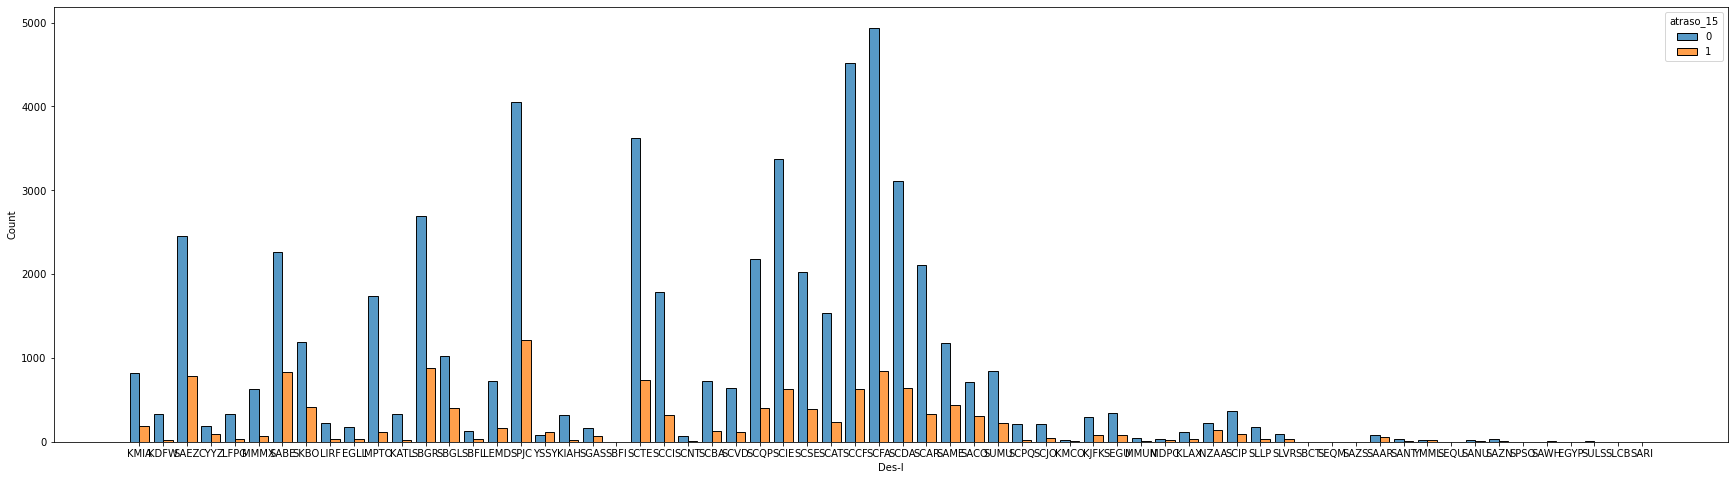

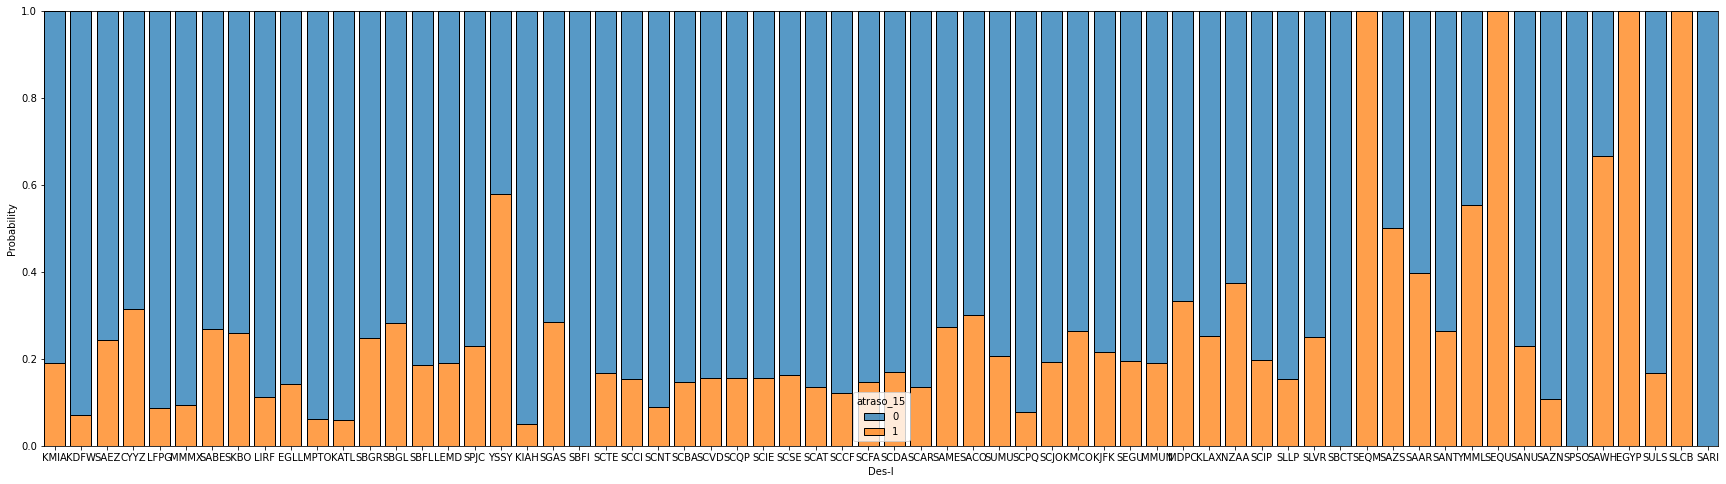

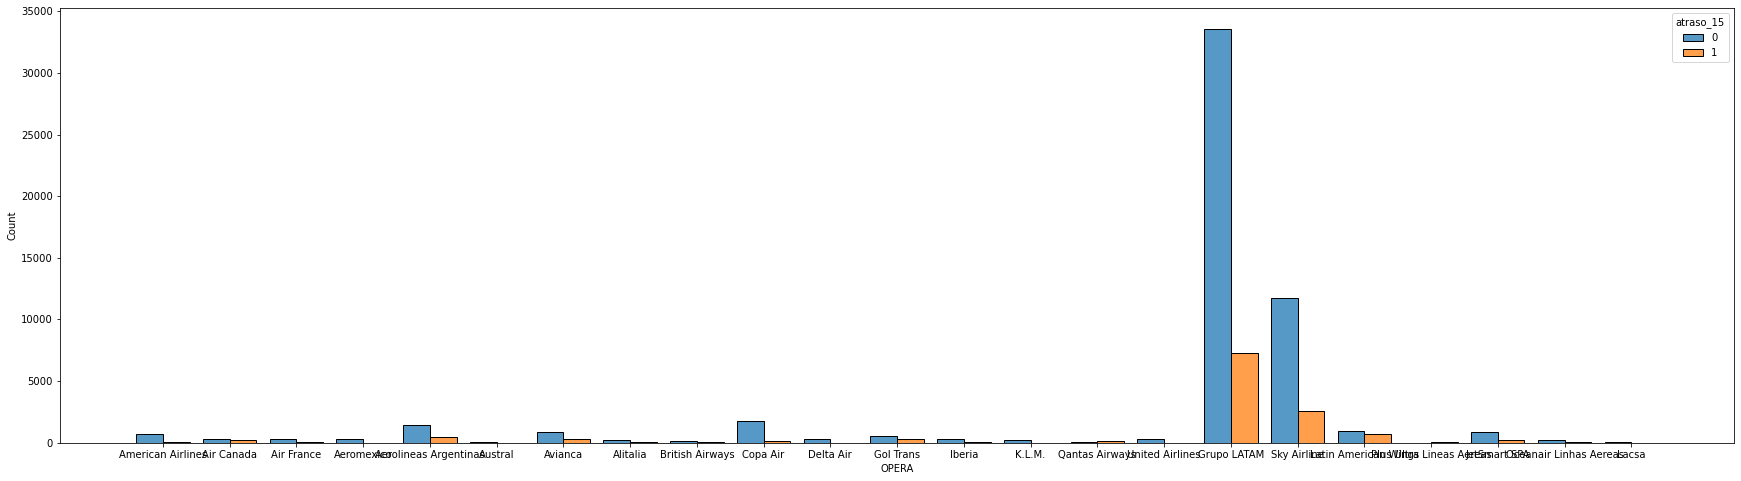

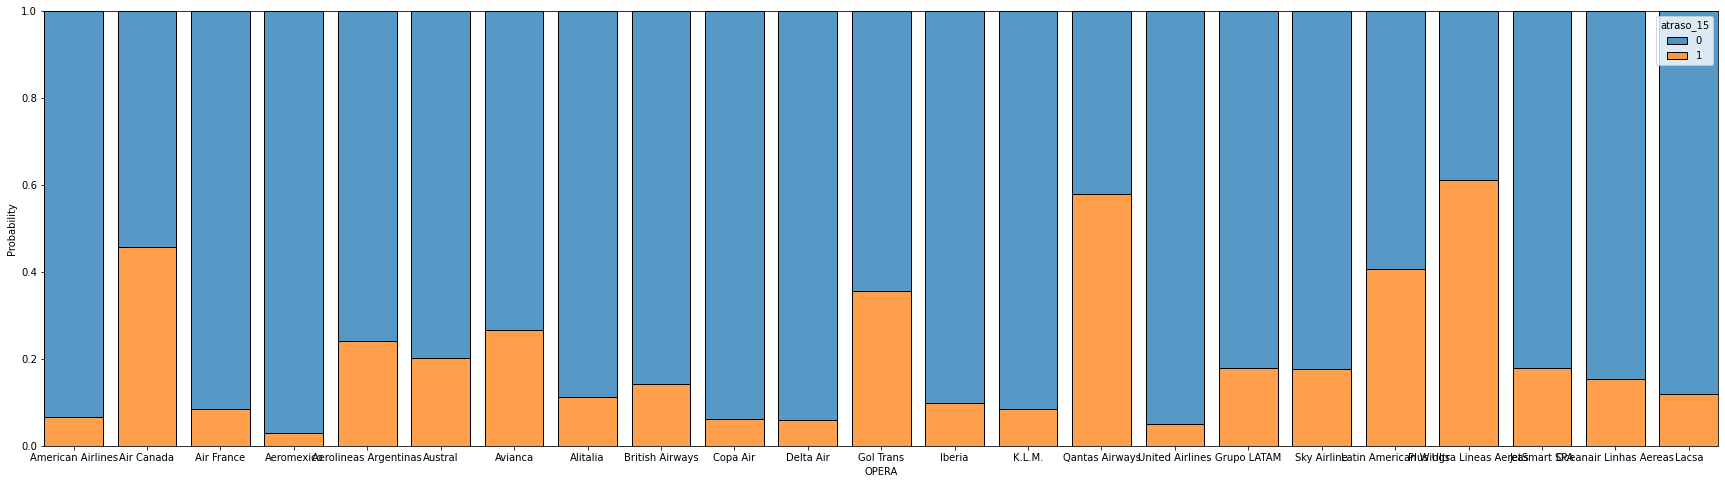

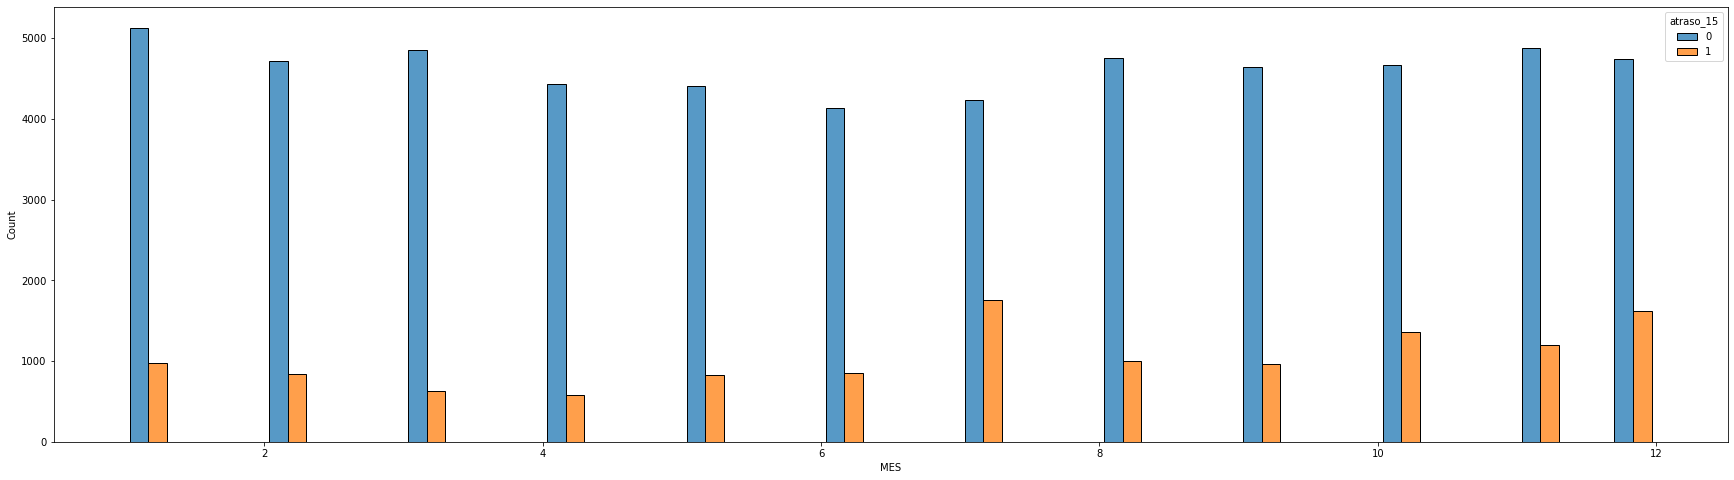

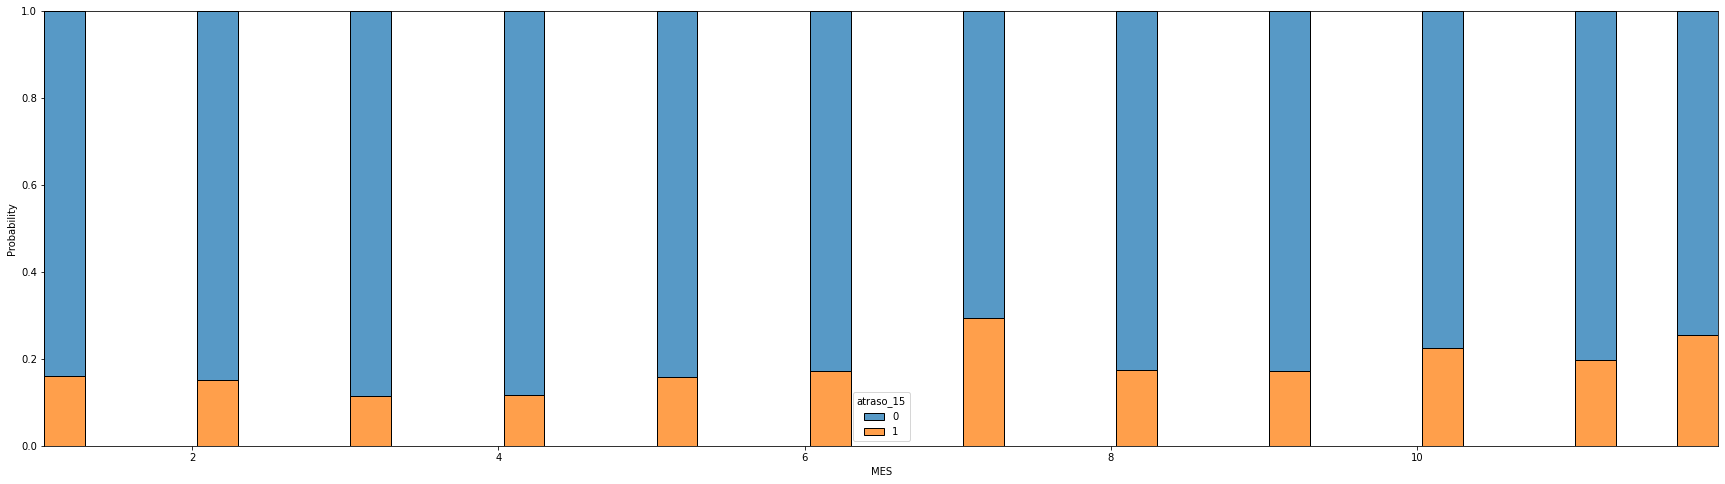

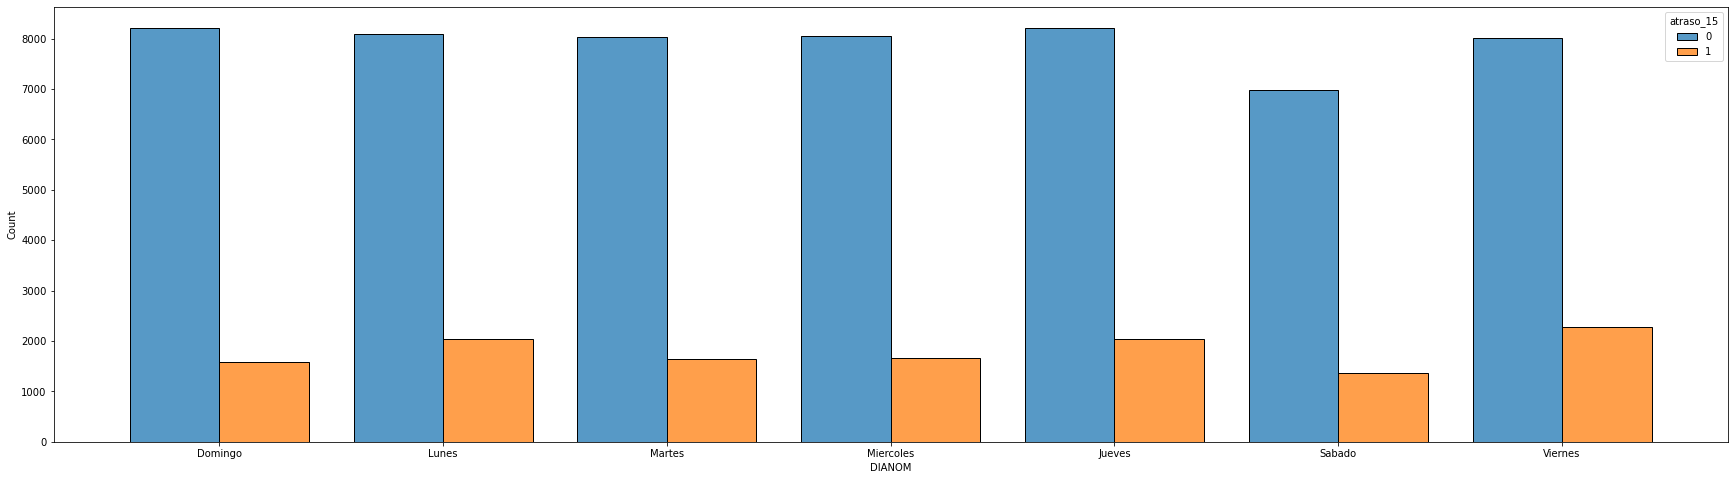

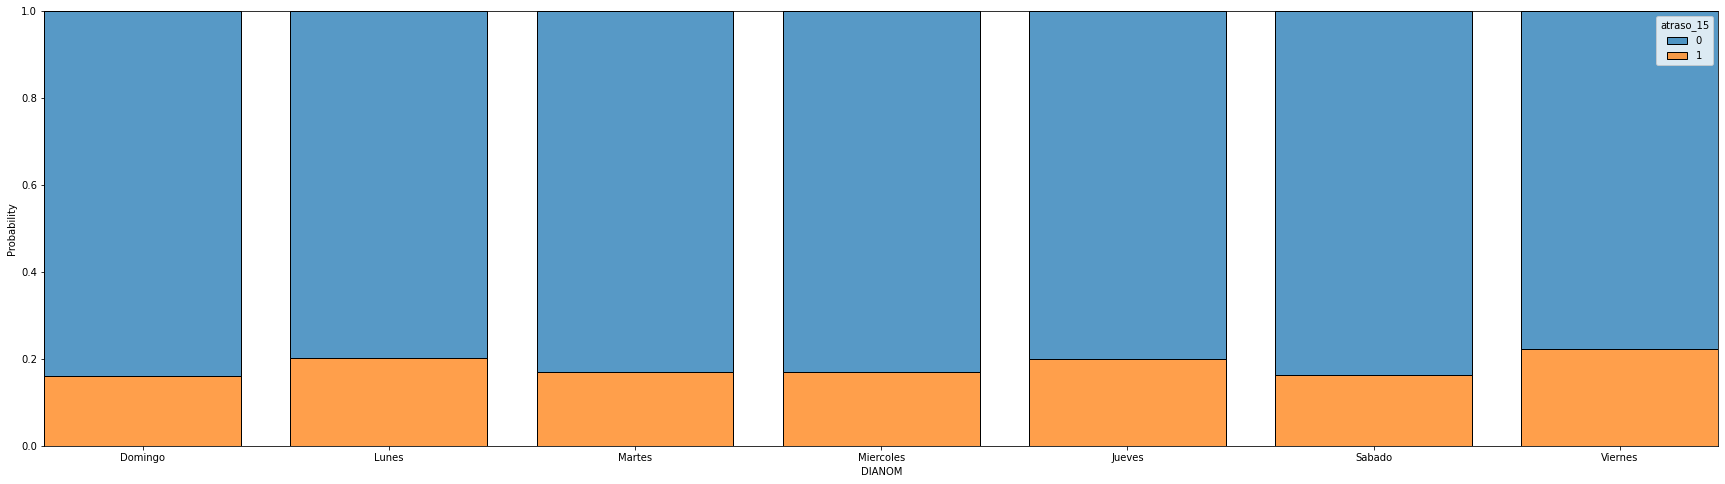

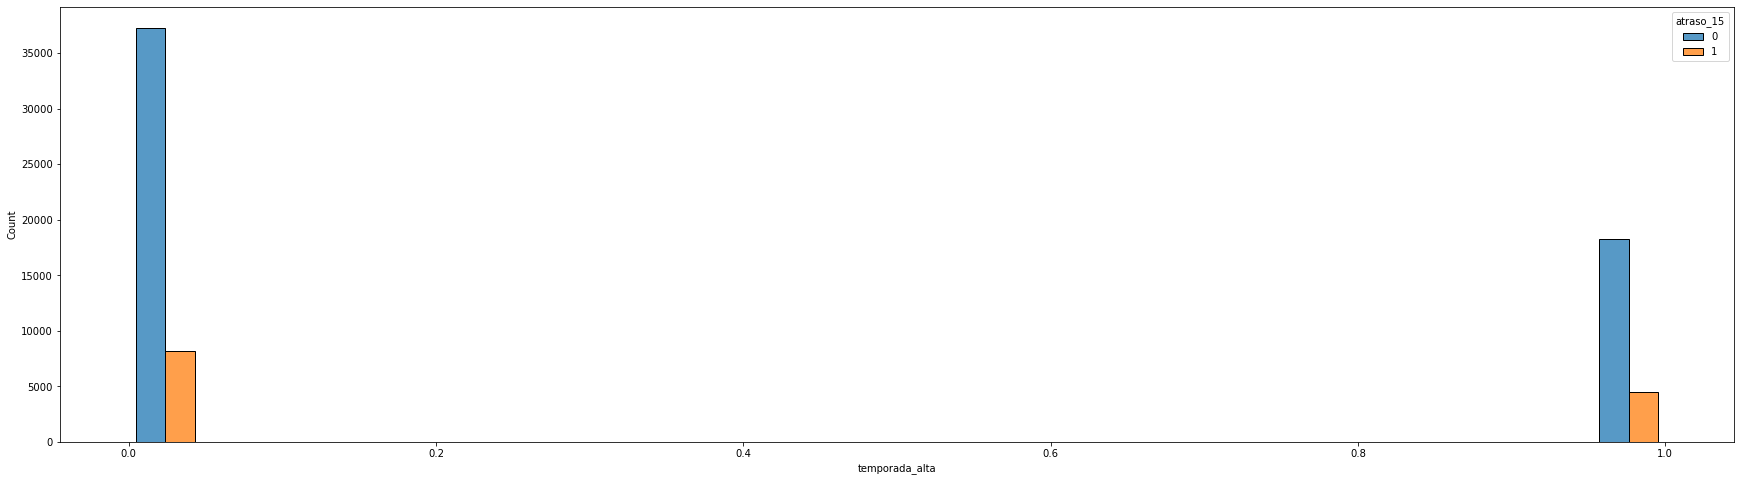

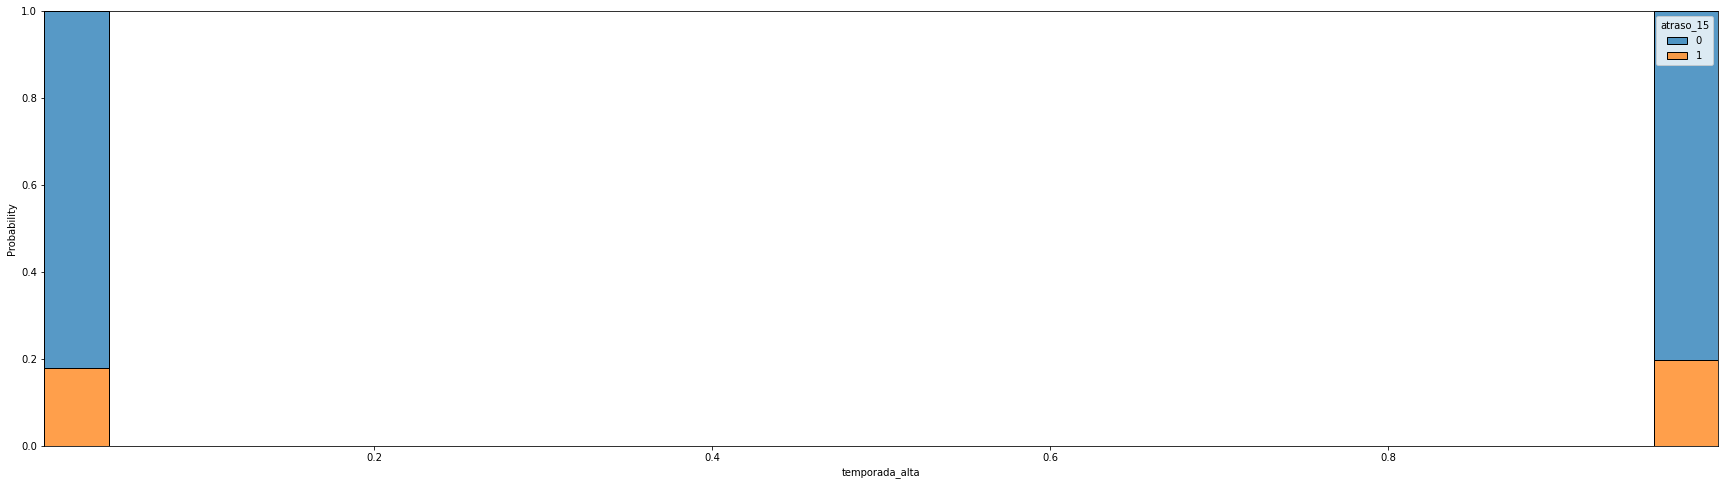

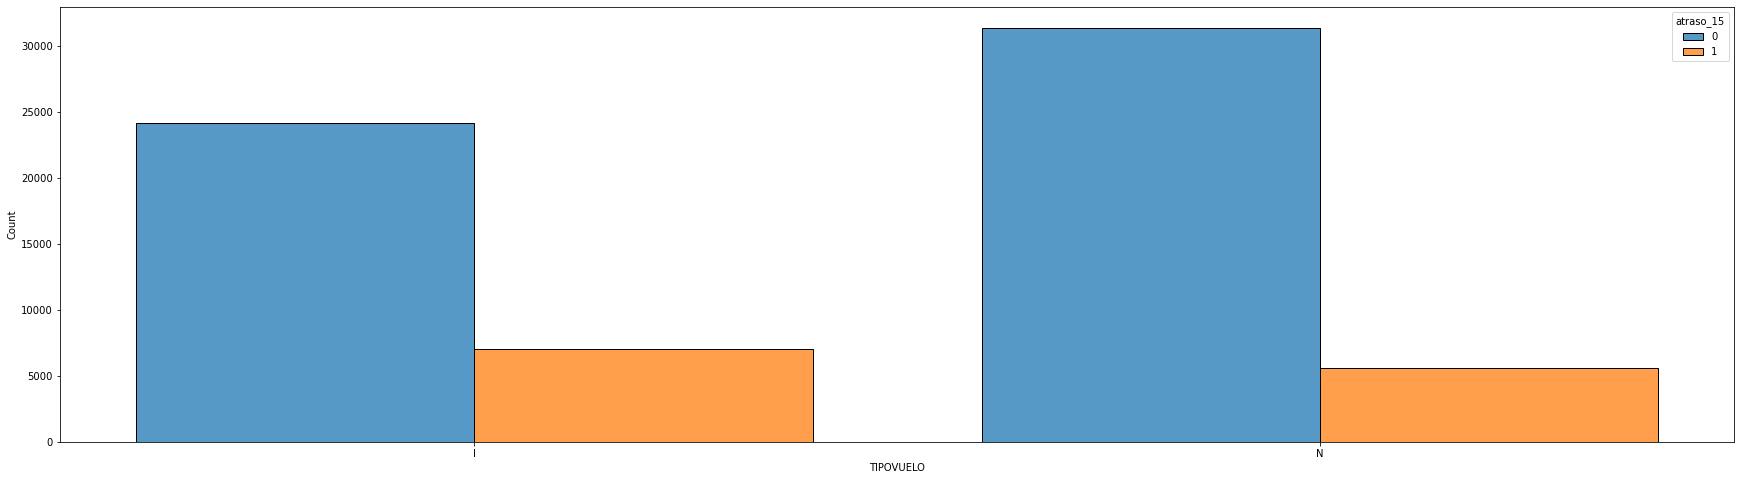

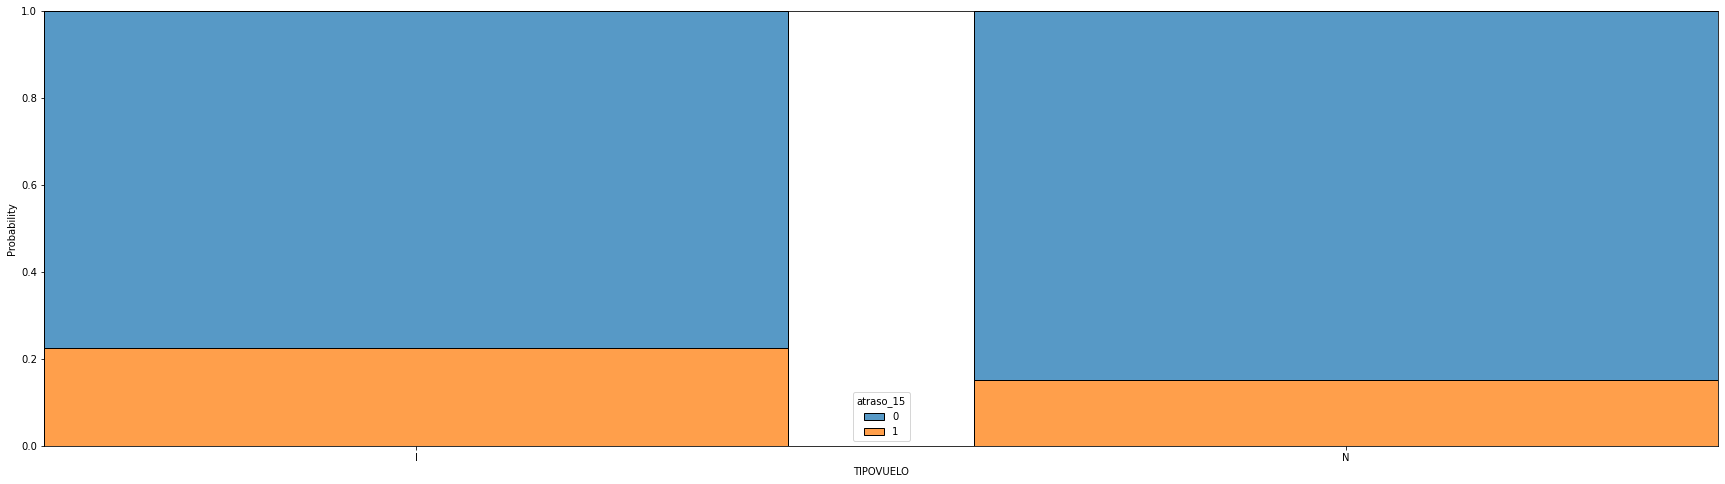

In [9]:
df_hist=df2[['Des-I','OPERA', 'MES','DIANOM', 'temporada_alta', 'TIPOVUELO']]
for n in range(len(df_hist.columns)):
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()

### Capturas_PowerBI_2

Suma dif_min y cantidad de vuelos vs hora para todo el dataset

![title](img/PBI6.png)  

Suma dif_min vs cantidad de vuelos por hora para todo el dataset  

![title](img/PBI7.png)

Correlaciones de suma de dif_min vs vs cantidad de vuelos por hora, DANOM, Día, y Mes para todo el dataset

![title](img/PBI8.png)

Ídem anterior solo para vuelos internacionales del Grupo LATAM 

![title](img/PBI9.png)


### Nuevas variables

Luego de las primeras pruebas se intentó mejorar los resultados agregando nuevas variables

In [10]:
#Nueva Variable, cambios en la ciudad de destino
#New dataframe: df_n
df_n=df2
df_n['Cambio_destino'] = np.where(df_n['Des-O']==df_n['Des-I'], 0, 1)
df_n['Cambio_destino'].sum()
#Hay demasiado pocos (28) cambios como para usar la variable se deja de todos modos para luego descartala

28

In [11]:
#Nueva Vaiable Fecha sin hora (sirve para cruzar con datos clima)
df_n['Fecha']= df_n['Fecha-I'].dt.date

#Nueva variable hora del día Puede ser importante a comprobar con Random Forest
df_n['Hora']=df_n['Fecha-I'].dt.hour

df_n.tail()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia,Cambio_destino,Fecha,Hora
68201,2017-12-22 14:55:00,'400',SCEL,SPJC,JAT,2017-12-22 15:41:00,'400.0',SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,1,46.0,1,tarde,0,2017-12-22,14
68202,2017-12-25 14:55:00,'400',SCEL,SPJC,JAT,2017-12-25 15:11:00,'400.0',SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,1,16.0,1,tarde,0,2017-12-25,14
68203,2017-12-27 14:55:00,'400',SCEL,SPJC,JAT,2017-12-27 15:35:00,'400.0',SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,1,40.0,1,tarde,0,2017-12-27,14
68204,2017-12-29 14:55:00,'400',SCEL,SPJC,JAT,2017-12-29 15:08:00,'400.0',SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,1,13.0,0,tarde,0,2017-12-29,14
68205,2017-12-31 14:55:00,'400',SCEL,SPJC,JAT,2017-12-31 15:04:00,'400.0',SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,1,9.0,0,tarde,0,2017-12-31,14


### Variables climáticas

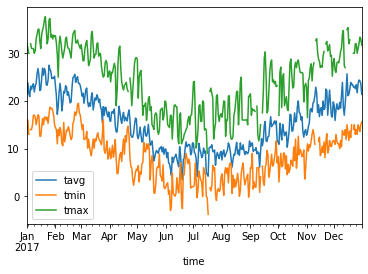

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2017-12-27,23.6,15.0,31.0,NaN,NaN,NaN,15.0,NaN,1015.8,NaN
2017-12-28,24.4,14.4,32.0,0.0,NaN,NaN,14.0,NaN,1014.4,NaN
2017-12-29,24.2,13.6,33.4,0.0,NaN,NaN,14.0,NaN,1013.5,NaN
2017-12-30,23.6,15.0,33.0,0.0,NaN,NaN,16.0,NaN,1014.3,NaN
2017-12-31,21.4,15.6,31.7,0.0,NaN,NaN,14.8,NaN,1014.1,NaN


In [12]:
#Se logró traer datos climáticos usando meteostat
from datetime import datetime
from meteostat import Point, Daily

# Mismo período de datos de 
start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)

# Create Point for SCL aeropuerto
SCL = Point(-33.3881063460988, -70.79442620963134) #from Gmaps: Airport Comodoro Arturo Merino Benitez


# Get daily data for 2017
metdata = Daily(SCL, start, end)
metdata = metdata.fetch()

# Plot line chart including average, minimum and maximum temperature
metdata.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()
metdata.tail()

In [13]:
# Transformación necesaria para poder unir los dataframes

metdata['Fecha']=metdata.index.to_series()
metdata['Fecha']= metdata['Fecha'].dt.date

In [14]:
#Merge del dataframe original con los datos de clima buscando coincidencias en el campo 'Fecha'

df_n=pd.merge(df_n, metdata, on='Fecha')
df_n=df_n.fillna(0)
df_n.tail()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
68201,2017-12-26 07:00:00,'203',SCEL,SCIE,JAT,2017-12-26 07:01:00,'203.0',SCEL,SCIE,JAT,...,21.7,13.0,30.0,0.0,0.0,0.0,16.5,0.0,1015.3,0.0
68202,2017-12-26 10:37:00,'251',SCEL,SCTE,JAT,2017-12-26 10:39:00,'251.0',SCEL,SCTE,JAT,...,21.7,13.0,30.0,0.0,0.0,0.0,16.5,0.0,1015.3,0.0
68203,2017-12-26 18:51:00,'255',SCEL,SCTE,JAT,2017-12-26 19:11:00,'255.0',SCEL,SCTE,JAT,...,21.7,13.0,30.0,0.0,0.0,0.0,16.5,0.0,1015.3,0.0
68204,2017-12-26 14:23:00,'281',SCEL,SCQP,JAT,2017-12-26 14:29:00,'281.0',SCEL,SCQP,JAT,...,21.7,13.0,30.0,0.0,0.0,0.0,16.5,0.0,1015.3,0.0
68205,2017-12-26 04:05:00,'301',SCEL,SCCI,JAT,2017-12-26 04:05:00,'301.0',SCEL,SCCI,JAT,...,21.7,13.0,30.0,0.0,0.0,0.0,16.5,0.0,1015.3,0.0


### Elección de Dataset

In [16]:
# #Defino variable a clasificar y remuevo algunas problemáticas
# target_name = "atraso_15"
# target = df2[target_name]

# #Remuevo algunas problematicas: Formato de Fecha-I no es compatible, "dif_min" y "Fecha-O" no se pueden usar poruqe no estarán disponibles para las predicciones

# data = df2.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min"]) 

In [17]:
# #Definición de target y resto de data para el dataset completo 
# #(los campos que se bajaron fueron haciendo pruebas de performance de los algoritmos, importancia den RF y posibles redundancia de información

# target_name = "atraso_15"
# target = df_n[target_name]

# #Primero removimos las variables que no era posible usar, Luego las que eran menos importantes usando Random Forest, y luego aquellas redundantes entre si
# # data = df_n.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min"])
# data = df_n.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min", "TIPOVUELO", "wdir", "Cambio_destino", 
#                           "AÑO", "Ori-O","snow", "Ori-I", "wpgt", "SIGLAORI","tsun", 'Vlo-O', 'tmin', 'tmax', 'Emp-O',
#                           'DIA', 'MES', 'SIGLADES', 'OPERA', 'temporada_alta', 'prcp', 'tavg', 'Des-O'])

In [ ]:
# Separo test y training set (default value es 25% - 75%)

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)


## Pipeline de Datos y Modelado

#### Pipeline para Multi-layer Perceptron, SVM y Logistic Regressions (OneHotEncoder y estandarización)

In [ ]:
# Segregación de variables númericas y categóricas según el dataframe que ingreso

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [ ]:
# Defino tipo de procesamiento de datos

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [ ]:
# Defino el preprocesador

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [ ]:
#Creo Pipline elijiendo el algoritmo (se puede habilitar o no SMOTE)

#Para usar smote simplemnte agredo sm en make_pipeline luedo de prepocessor

sm = SMOTE(random_state=42) 

#Multi-layer Perceptron

clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model_nn = make_pipeline(preprocessor, sm, clf_nn)

#Logisitic Regression

model_lr = make_pipeline(preprocessor, sm, LogisticRegression(max_iter=500))

#Support Vector Classification

model_svm = make_pipeline(preprocessor, sm, svm.SVC(kernel='linear'))



In [ ]:
%%time

#Entrenamiento Multi-layer Perceptron

_ = model_nn.fit(data_train, target_train)


#Vizualización del Pipeline

set_config(display='diagram')
model_nn



In [ ]:
#Calculo las predicciones

predictions_nn = model_nn.predict(data_test)

#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_nn))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_nn))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_nn)))

print(classification_report(target_test, predictions_nn))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_nn, data_test, target_test) 
plt.show()

In [25]:
%%time

#Entrenamiento Logisitic Regression

_ = model_lr.fit(data_train, target_train)

#Vizualización del Pipeline

set_config(display='diagram')
model_lr


Wall time: 3.66 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vlo-I', 'Ori-I', 'Des-I',
                                                   'Emp-I', 'Vlo-O', 'Ori-O',
                                                   'Des-O', 'Emp-O', 'DIANOM',
                                                   'TIPOVUELO', 'OPERA',
                                                   'SIGLAORI', 'SIGLADES',
                                                   'periodo_dia', 'Fecha']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['DIA', 'MES', 'AÑO',
                                                   'temporada_alta',
                                                   'Cambio_destino', 'Hora',
                                                   'tavg', 'tmin', 'tmax',
                                                   'prcp', 'snow', 'wdir',
                                                   'wspd', 'wpgt', 'pres',
                                                   'tsun'])])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [ ]:
#Calculo las predicciones

predictions_lr = model_lr.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_lr))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_lr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_lr)))

print(classification_report(target_test, predictions_lr))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_lr, data_test, target_test) 
plt.show()

In [27]:
# %%time
# #Entrenamiento Support Vector Classification (se deja comentado por el tiempo de corrida)
# _ = model_svm.fit(data_train, target_train)

# #Vizualización del Pipeline

# set_config(display='diagram')
# model_svm

# #Resultados corrida
# #Wall time: 4min 37s
# #0.817558057705841

In [28]:
# #Calculo las predicciones

# predictions_svm = model_svm.predict(data_test)


# #Métricas para evaluar el modelo

# print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_svm))
# print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_svm))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_svm)))

# print(classification_report(target_test, predictions_svm))
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(model_svm, data_test, target_test) 
# plt.show()

#### Pipeline para Árboles, RF y Gradient-boosting Trees (más simple: puedo usar Ordinal encoder y no necesito normalizar las variables numéricas) 

In [29]:
# Segregación de variables númericas y categóricas según el dataframe que ingreso

categorical_columns_selector = selector(dtype_include=object)


categorical_columns_2 = categorical_columns_selector(data)

In [30]:
# Defino tipo de procesamiento de datos

categorical_preprocessor_2 = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)


In [31]:
# Defino el preprocesador

preprocessor_2 = ColumnTransformer([
    ('categorical', categorical_preprocessor_2, categorical_columns_2)],
    remainder="passthrough")


In [32]:
#Creo Pipline elijiendo el algoritmo (se puede habilitar o no SMOTE)

#Para usar SMOTE simplemnte agredo sm en make_pipiline luedo de prepocessor

sm = SMOTE(random_state=42)

# Gradient-boosting Trees

clf_gb=HistGradientBoostingClassifier()
model_gb = make_pipeline(preprocessor_2, clf_gb)

# Decision Tree simple

clf_dt=DecisionTreeClassifier(random_state=25)
model_dt = make_pipeline(preprocessor_2,sm, clf_dt)

# Random Forest

clf_rf=RandomForestClassifier(n_estimators=100)
model_rf = make_pipeline(preprocessor_2, clf_rf)


In [ ]:
%%time

#Entrenamiento Gradient-boosting Trees

_ = model_gb.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_gb.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_gb

In [ ]:
#Calculo las predicciones

predictions_gb = model_gb.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_gb))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_gb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_gb)))

print(classification_report(target_test, predictions_gb))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_gb, data_test, target_test) 

plt.show()

In [35]:
%%time

#Entrenamiento Decision Tree simple

_ = model_dt.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_dt.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_dt

Wall time: 767 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Vlo-I', 'Ori-I', 'Des-I',
                                                   'Emp-I', 'Vlo-O', 'Ori-O',
                                                   'Des-O', 'Emp-O', 'DIANOM',
                                                   'TIPOVUELO', 'OPERA',
                                                   'SIGLAORI', 'SIGLADES',
                                                   'periodo_dia', 'Fecha'])])),
                ('smote', SMOTE(random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=25))])

Mean Absolute Error: 0.22765635143908244
Mean Squared Error: 0.22765635143908244
Root Mean Squared Error: 0.47713347340034995
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      7787
           1       0.28      0.29      0.28      1455

    accuracy                           0.77      9242
   macro avg       0.57      0.58      0.57      9242
weighted avg       0.77      0.77      0.77      9242



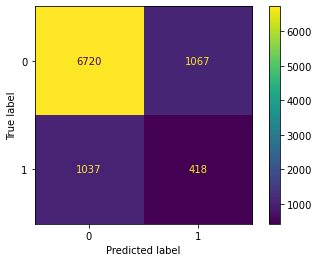

In [36]:
#Calculo las predicciones

predictions_dt = model_dt.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_dt))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_dt)))

print(classification_report(target_test, predictions_dt))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_dt, data_test, target_test) 
plt.show()

In [37]:
%%time

#Entrenamiento Random Forest

_ = model_rf.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_rf.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_rf

Wall time: 3.31 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Vlo-I', 'Ori-I', 'Des-I',
                                                   'Emp-I', 'Vlo-O', 'Ori-O',
                                                   'Des-O', 'Emp-O', 'DIANOM',
                                                   'TIPOVUELO', 'OPERA',
                                                   'SIGLAORI', 'SIGLADES',
                                                   'periodo_dia', 'Fecha'])])),
                ('randomforestclassifier', RandomForestClassifier())])

Mean Absolute Error: 0.15429560701146938
Mean Squared Error: 0.15429560701146938
Root Mean Squared Error: 0.3928047950464319
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7787
           1       0.53      0.17      0.26      1455

    accuracy                           0.85      9242
   macro avg       0.70      0.57      0.58      9242
weighted avg       0.81      0.85      0.81      9242



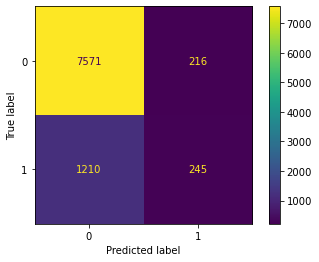

In [38]:
#Calculo las predicciones

predictions_rf = model_rf.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_rf))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_rf)))

print(classification_report(target_test, predictions_rf))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_rf, data_test, target_test) 
plt.show()

### Feature Selection

In [39]:
#Orden de importancia de variables según RF, y agregado de nombres traídos del pipeline

feature_imp = pd.Series(clf_rf.feature_importances_, index=model_rf[:-1].get_feature_names_out()).sort_values(ascending=False)
feature_imp


categorical__Vlo-O           0.112341
categorical__Vlo-I           0.109296
remainder__Hora              0.103427
categorical__Fecha           0.066257
remainder__tavg              0.052618
categorical__SIGLADES        0.052493
remainder__tmin              0.050490
categorical__Des-I           0.050364
remainder__DIA               0.050119
categorical__Des-O           0.049701
remainder__wspd              0.048174
remainder__tmax              0.047636
remainder__pres              0.046330
categorical__DIANOM          0.033132
categorical__periodo_dia     0.026127
categorical__Emp-O           0.025676
remainder__MES               0.024317
categorical__Emp-I           0.016476
categorical__OPERA           0.015424
remainder__prcp              0.008447
remainder__temporada_alta    0.006821
remainder__wdir              0.004206
remainder__Cambio_destino    0.000128
remainder__snow              0.000000
remainder__wpgt              0.000000
categorical__TIPOVUELO       0.000000
categorical_

No handles with labels found to put in legend.


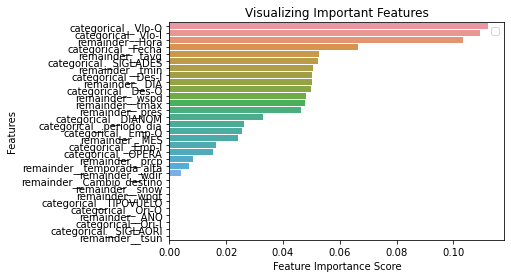

In [40]:
# Gráfico de importancia de variables según RF

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [41]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyper Parameter tunning para RF

In [42]:
%%time
# Random Forest hyperparameter tuning

clf_rf=RandomForestClassifier()
model_rf = make_pipeline(preprocessor_2, sm, clf_rf)
pipe_params = {
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__n_estimators": [100, 500, 1000],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "randomforestclassifier__max_features": ['auto', 'sqrt'],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

# gridsearch = GridSearchCV(
#     model_rf, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1000
# )
rf_random = RandomizedSearchCV(model_rf, param_distributions = pipe_params, n_iter = 25, scoring='f1_macro', cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(data_train, target_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

In [43]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
predictions_rf = rf_random.predict(data_test)
f1_score(target_test,predictions_rf, average='macro')

In [ ]:
optimised_random_forest = rf_random.best_estimator_

In [ ]:
predictions_rfb = optimised_random_forest.predict(data_test)
f1_score(target_test,predictions_rf, average='macro')

In [ ]:
#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_rf))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_rf)))

print(classification_report(target_test, predictions_rf))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(optimised_random_forest, data_test, target_test) 
plt.show()

## Apendice

In [ ]:
#revisemos las información que nos brinda pandas sobre el tipo de datos
df.info()

In [ ]:
#descriptive statistics summary variables numérricas
df.describe()

In [ ]:
#descriptive statistics summary para variables categóricas
df[['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES']].describe()

In [ ]:
#Una primera mirada de los datos
df.head()

In [ ]:
df.tail()

In [ ]:
#Porcentaje de vuelos según aerolínea
df['Emp-O'].value_counts(normalize = True)*100

In [ ]:
#Número de vuelos por código de vuelo
df['Vlo-O'].value_counts()

### Pie_charts

In [ ]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100

for n in range(len(df.columns)):
    colors = sns.color_palette('pastel')[0:len(df[list(df.columns.values)[n]].value_counts())]
    plt.figure(figsize=(12, 12))
    plt.title((df.columns.values)[n])
    plt.pie(df[list(df.columns.values)[n]].value_counts().head(top),labels=df[list(df.columns.values)[n]].value_counts().head(top).index.tolist(), autopct='%1.1f%%', colors=colors)
plt.show()

### Bar_charts

In [ ]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100

for n in range(len(df.columns)):
    count_order = df[list(df.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df, y=list(df.columns.values)[n], order=count_order)
plt.show()


### Histoplots

In [ ]:
for n in range(len(df2.columns)):
    plt.figure(figsize=(24, 12))
    sns.histplot(data=df, x=list(df2.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(24, 12))
    sns.histplot(data=df, x=list(df2.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()


### Bar_charts_new_variables

In [ ]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_bar_n=df_n[['Cambio_destino','Fecha', 'Hora','tavg', 'tmin', 'wspd', 'tmax', 'pres', 'prcp', 'wdir', 'snow', 'wpgt', 'tsun']]
for n in range(len(df_bar_n.columns)):
    count_order = df_bar_n[list(df_bar_n.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df_bar_n, y=list(df_bar_n.columns.values)[n], order=count_order)
plt.show()


### Histoplots_new_variables

In [ ]:
df_hist_n=df_n[['Cambio_destino','Fecha', 'Hora']]
for n in range(len(df_hist_n.columns)):
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist_n.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist_n.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()

### Detalles_numericos_tasas

In [ ]:
# Cantidad de atrasos y porcentajes según categorías
var=df['Des-I']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

In [ ]:
# Cantidad de atrasos y porcentajes según categorías
var=df['TIPOVUELO']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

In [ ]:
# Cantidad de atrasos y porcentajes según categorías
var=df['DIANOM']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

### Detalles_numerico_desbalance

In [ ]:
#Chequeo porcentaje de atraso_15 (para ver desbalance de categorías a predecir)
var=df['atraso_15']
pd.crosstab(var,df['atraso_15'],normalize='columns', margins=True)*100

### Histograma_de_dif_min

In [ ]:
#histograma del atraso
sns.distplot(df['dif_min']);
#skewness and kurtosis
print("Skewness: %f" % df['dif_min'].skew())
print("Kurtosis: %f" % df['dif_min'].kurt())

Referencia:
Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.(close to 0 for a normal distribution)

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. (close to 3 for a normal distribution)

Al analizar el [histograma de la variable dif_min](#Histograma_de_dif_min) se puede ver que el atraso no es simétrico (Skewness=3.5 en lugar de cercano a cero) y que tiene una rango de datos muy amplio, extendiendose hacia valores positivos grandes comparado con la distribución normal (Kurtosis=16.8 en lugar de ser cercana a 3), esto puede traer problemas con algunos algoritmos si se pretendiese predecir esta variable. 

In [ ]:
df_n[['Cambio_destino','Fecha', 'Hora','tavg', 'tmin', 'wspd', 'tmax', 'pres', 'prcp', 'wdir', 'snow', 'wpgt', 'tsun']].to_csv('new_features.csv')

### Pairplot new variables

In [ ]:
# #Se deja comentado y la imagen abajo porque tarda mucho en correr
# datag = df_n
# sns.pairplot(data=datag, hue='atraso_15')
# plt.show()

Se guardó la imagen de salida porque tarda mucho en correr:
![title](img/graf2.png)